# Movie Recommender System

We have to Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### Concepts Tested: Concepts Tested:



Recommender Engine

Collaborative Filtering (Item-based & User-based Approach)

Pearson Correlation

Nearest Neighbors using Cosine Similarity

Matrix Factorization

### Importing Library

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
import warnings

In [77]:
pip install cmfrec

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 268 kB 1.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached findblas-0.1.21-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post4-cp39-cp39-linux_x86_64.whl size=1549215 sha256=ae6d5e6b8950b0e853fa52e1cb38fdcb60f9774b6709170d7fad3e12f2257cf6
  Stored in directory: /home/T7820S1/.cache/pip/wheels/fb/34/7e/98161f512b5008289e510c24b61e69b010bdebc26478273200
Successfully built cmfrec
Note: you may need to restart the kernel to use updated packages.


In [78]:
from collections import defaultdict 
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [60]:
warnings.simplefilter('ignore')

## Data Exploration and Formatting

In [3]:
data1=pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
data1.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [4]:
data1.shape

(1000209, 1)

In [5]:
data2=pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
data2.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [6]:
data2.shape

(3883, 3)

In [7]:
data3=pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')
data3.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [8]:
data3.shape

(6040, 1)

In [9]:
def correct_format_df(df):
    col=df.columns[0]
    col1=df.columns[0].split('::')
    df1=df[col].str.split('::', expand=True)
    df1.columns=col1
    return df1

In [10]:
rating=correct_format_df(data1)
rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
users=correct_format_df(data3)
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
movies=correct_format_df(data2)
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies['Genres'].value_counts()

Drama                                            830
Comedy                                           518
Horror                                           172
Comedy|Drama                                     159
Comedy|Romance                                   136
                                                ... 
Action|Adventure|Children's                        1
Action|Adventure|Children's|Fantasy                1
Action|Adventure|Sci-Fi|Th                         1
Adventure|Animation|Children's|Comedy|Musical      1
Drama|Fantas                                       1
Name: Genres, Length: 360, dtype: int64

In [13]:
dfmov = movies.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov['Genres'] = dfmov['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])
for i in dfmov['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'
dfmov.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [28]:
dfmov.rename(columns={'Movie ID':'MovieID'},inplace=True)

In [29]:
dfmov.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [30]:
df_1 = pd.merge(dfmov, rating, how='inner', on='MovieID')
df_1.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1,5,978824268
1,1,Toy Story (1995),"[Animation, Children's, Comedy]",6,4,978237008
2,1,Toy Story (1995),"[Animation, Children's, Comedy]",8,4,978233496
3,1,Toy Story (1995),"[Animation, Children's, Comedy]",9,5,978225952
4,1,Toy Story (1995),"[Animation, Children's, Comedy]",10,5,978226474


In [31]:
data = pd.merge(df_1, users, how='inner', on='UserID')
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),"[Animation, Children's, Musical, Romance]",1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),[Drama],1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy]",1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),"[Drama, War]",1,5,978824195,F,1,10,48067


## Preparing the dataset

In [34]:
data.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [35]:
data.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [150]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
data['Year'] = data.Title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
data['Year'] = data.Year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'Title' column
data['Title'] = data.Title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
data['Title'] = data['Title'].apply(lambda x: x.strip())
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Year,ReleaseDec,Datetime
0,1,Toy Story,"[Animation, Children's, Comedy]",1,5,978824268,F,Under 18,k-12 student,48067,NaN,90s,2001-01-06 23:37:48
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1,5,978824351,F,Under 18,k-12 student,48067,NaN,90s,2001-01-06 23:39:11
2,150,Apollo 13,[Drama],1,5,978301777,F,Under 18,k-12 student,48067,NaN,90s,2000-12-31 22:29:37
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1,4,978300760,F,Under 18,k-12 student,48067,NaN,70s,2000-12-31 22:12:40
4,527,Schindler's List,"[Drama, War]",1,5,978824195,F,Under 18,k-12 student,48067,NaN,90s,2001-01-06 23:36:35


In [33]:
data.shape

(996144, 10)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     996144 non-null  object
 1   Title       996144 non-null  object
 2   Genres      996144 non-null  object
 3   UserID      996144 non-null  object
 4   Rating      996144 non-null  object
 5   Timestamp   996144 non-null  object
 6   Gender      996144 non-null  object
 7   Age         996144 non-null  object
 8   Occupation  996144 non-null  object
 9   Zip-code    996144 non-null  object
 10  Year        996144 non-null  object
dtypes: object(11)
memory usage: 91.2+ MB


In [43]:
data['Year']=data['Year'].astype(int)
data['Rating']=data['Rating'].astype(int)

In [46]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s') 

In [47]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['Year'], bins=bins, labels=labels)
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Year,ReleaseDec,Datetime
0,1,Toy Story,"[Animation, Children's, Comedy]",1,5,978824268,F,Under 18,k-12 student,48067,1995,90s,2001-01-06 23:37:48
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1,5,978824351,F,Under 18,k-12 student,48067,1995,90s,2001-01-06 23:39:11
2,150,Apollo 13,[Drama],1,5,978301777,F,Under 18,k-12 student,48067,1995,90s,2000-12-31 22:29:37
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1,4,978300760,F,Under 18,k-12 student,48067,1977,70s,2000-12-31 22:12:40
4,527,Schindler's List,"[Drama, War]",1,5,978824195,F,Under 18,k-12 student,48067,1993,90s,2001-01-06 23:36:35


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MovieID     996144 non-null  object        
 1   Title       996144 non-null  object        
 2   Genres      996144 non-null  object        
 3   UserID      996144 non-null  object        
 4   Rating      996144 non-null  int64         
 5   Timestamp   996144 non-null  object        
 6   Gender      996144 non-null  object        
 7   Age         996144 non-null  object        
 8   Occupation  996144 non-null  object        
 9   Zip-code    996144 non-null  object        
 10  Year        996144 non-null  int64         
 11  ReleaseDec  996099 non-null  category      
 12  Datetime    996144 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2), object(9)
memory usage: 99.8+ MB


## Analysing the feature

In [49]:
user_ratings =data[['UserID','Rating']].groupby('UserID').mean()

Text(0, 0.5, 'Frequency')

<Figure size 576x576 with 0 Axes>

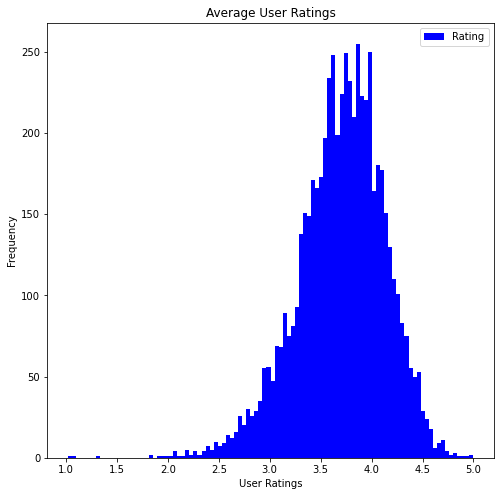

In [50]:
fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 100, figsize = (8,8), color = 'blue')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

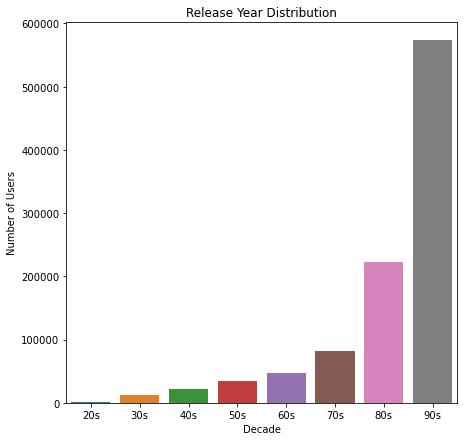

In [53]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

In [54]:
l = dfmov.Genres.iloc[:5]

In [149]:
pd.get_dummies(l.apply(pd.Series).stack()).sum(level=1)

,Adventure,Animation,Children's,Comedy,Drama,Fantasy,Romance
0,1,1,0,3,0,0,0
1,0,0,2,0,1,0,1
2,0,0,0,1,0,1,0


## Genres

In [61]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)
genres_df.head()

,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
### considering only the genre columns for the test
test = genres_df.iloc[:,0:].sum()
test=test.iloc[1:]
print(test)

Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1189
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64


In [63]:
print(type(pd.to_numeric(test)))
print(type(test.to_numpy().reshape(18,)[0]))
# genre_sum = np.hstack((np.asarray(genre_list).reshape(18,1), test.to_numpy().reshape(18,)))
# genre_sum[:,1] = genre_sum[:,1].astype('int64')
test2 = test.to_numpy().reshape(18,)

<class 'pandas.core.series.Series'>
<class 'numpy.int64'>


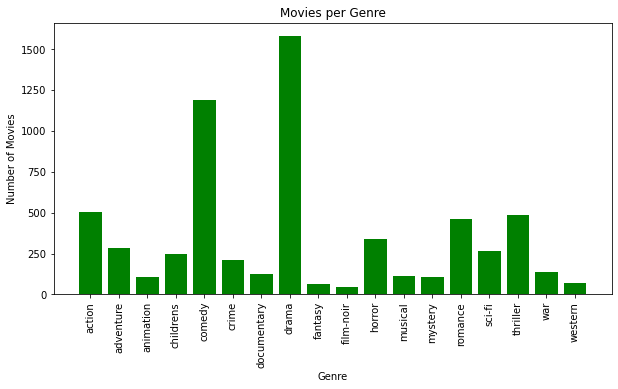

In [64]:
genre_list=['action', 'adventure','animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']
x = np.arange(18)
plt.figure(figsize = (10,5))
plt.bar(x, test2, color = 'g')
plt.xticks(x, genre_list, rotation = 'vertical')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre')
sns.set(font_scale=1.5)
plt.show()

### Distribution by age

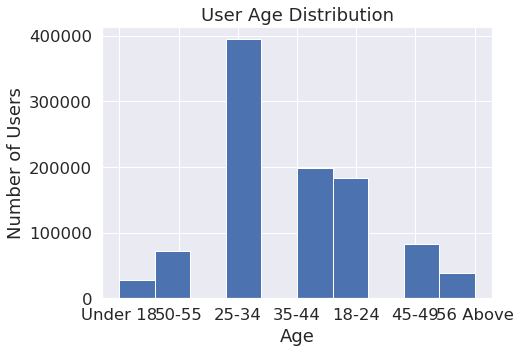

In [65]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

### Distribution by Gender

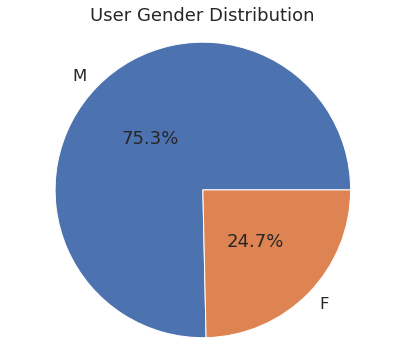

In [66]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

### Distribution by Operation

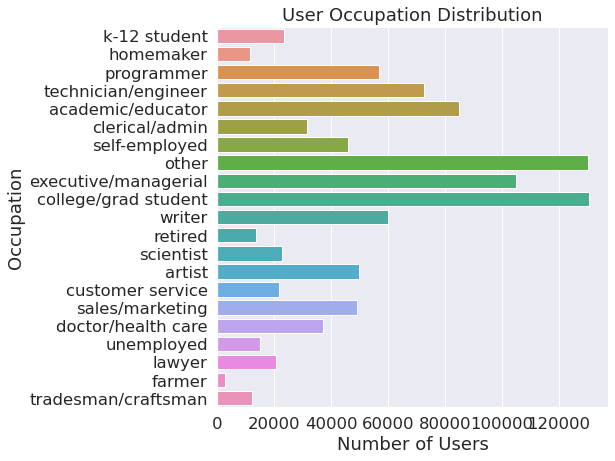

In [67]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

Text(0, 0.5, 'User Rating count')

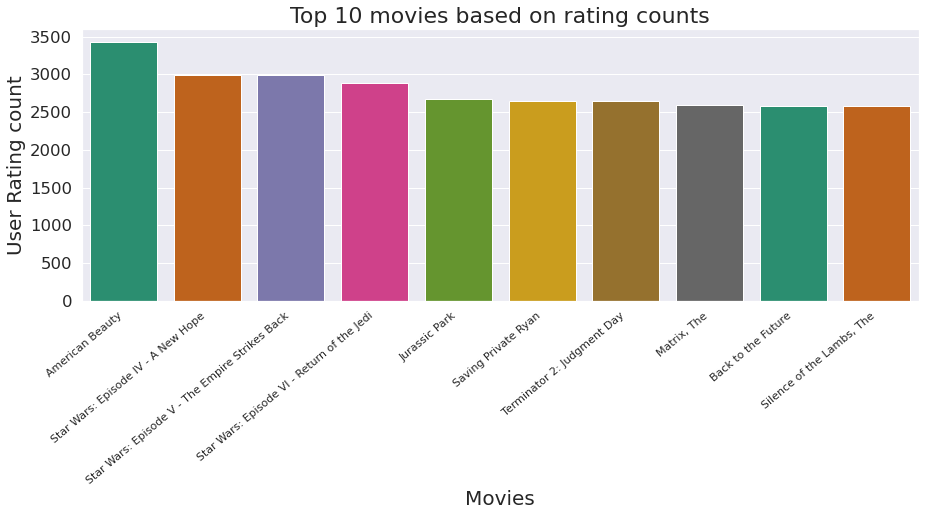

In [68]:
movies_rating_count = data.groupby(by = ['Title'])['Rating'].count().reset_index()[['Title', 'Rating']] ## Counting the ratings based on movies
movies_rating_count.rename(columns = {'Rating': 'totalRatingCount'},inplace=True)

top10_movies=movies_rating_count[['Title', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)

plt.figure(figsize=(15,5))
ax=sns.barplot(x="Title", y="totalRatingCount", data=top10_movies, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 movies based on rating counts',fontsize = 22)
ax.set_xlabel('Movies',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

## Recommender Systems

User Interaction Matrix

In [70]:
matrix = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
matrix.fillna(0, inplace=True) # Imputing 'NaN' values with Zero rating 

print(matrix.shape)

matrix.head()

(6040, 3640)


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0


In [71]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


## Pearson Correlation

#### Item Based Approach

In [72]:
data[data['Title']=='Home Alone']

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Year,ReleaseDec,Datetime
415,586,Home Alone,"[Children's, Comedy]",10,3,978228747,F,35-44,academic/educator,95370,1990,90s,2000-12-31 02:12:27
822,586,Home Alone,"[Children's, Comedy]",18,4,978155233,F,18-24,clerical/admin,95825,1990,90s,2000-12-30 05:47:13
1742,586,Home Alone,"[Children's, Comedy]",26,2,978140049,M,25-34,executive/managerial,23112,1990,90s,2000-12-30 01:34:09
2705,586,Home Alone,"[Children's, Comedy]",38,4,978046369,F,18-24,college/grad student,02215,1990,90s,2000-12-28 23:32:49
3015,586,Home Alone,"[Children's, Comedy]",45,3,977991192,F,45-49,self-employed,94110,1990,90s,2000-12-28 08:13:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975134,586,Home Alone,"[Children's, Comedy]",4273,5,989118624,M,45-49,retired,30030,1990,90s,2001-05-06 03:10:24
977745,586,Home Alone,"[Children's, Comedy]",3385,3,967564715,F,25-34,homemaker,32212,1990,90s,2000-08-29 15:58:35
981262,586,Home Alone,"[Children's, Comedy]",3633,4,966526025,M,35-44,tradesman/craftsman,60441,1990,90s,2000-08-17 15:27:05
990597,586,Home Alone,"[Children's, Comedy]",4846,3,962834091,F,25-34,artist,90066,1990,90s,2000-07-05 21:54:51


In [73]:
#movie_name = input("Enter a movie name: ")
movie_name='Home Alone'
movie_rating = matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

UserID
1       0.0
10      3.0
100     0.0
1000    0.0
1001    0.0
       ... 
995     0.0
996     0.0
997     0.0
998     0.0
999     0.0
Name: Home Alone, Length: 6040, dtype: float64


In [74]:
similar_movies = matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


### Cosine Similarity

In [79]:
item_sim = cosine_similarity(matrix.T) #Finding the similarity values between item-item using cosine_similarity
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

Item based

In [80]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head() #Item-similarity Matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


User based

In [81]:
user_sim = cosine_similarity(matrix) #Finding the similarity values between user-user using cosine_similarity
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [82]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


### Nearest Neighbours

In [83]:
model_knn = NearestNeighbors(metric='cosine') 
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [84]:
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors= 6)

In [85]:
result = pd.DataFrame(indices, columns=['Title1', 'Title2', 'Title3', 'Title4', 'Title5','Title6'])
result.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,735,416,286,584,3247
1,1,807,72,2167,3036,3369
2,2,1627,2529,3320,2588,1999
3,3,1457,2169,1308,1047,3511
4,4,26,726,894,495,944


In [86]:
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [87]:
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name]

,Title1,Title2,Title3,Title4,Title5,Title6
1887,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective,Dumb & Dumber,Home Alone,Wayne's World


### Matrix Factorization

Creating a pivot table of movie titles and userid and ratings are taken as values.

In [88]:
rm = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
user_itm = data[['UserID', 'MovieID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_itm.head(2)

,UserId,ItemId,Rating
0,1,1,5
1,1,48,5


In [90]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserId'].unique()))
print("No.of Items:",len(user_itm['ItemId'].unique()))

(996144, 3)
No.of Users: 6040
No.of Items: 3682


In [91]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False) 
model.fit(user_itm) #Fitting the model

Collective matrix factorization model
(explicit-feedback variant)


In [92]:
model.A_.shape, model.B_.shape 

((6040, 4), (3682, 4))

In [93]:
user_itm.Rating.mean(), model.glob_mean_

(3.57998542379415, 3.5799853801727295)

In [94]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ 

In [95]:
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse)) 

Root Mean Squared Error: 1.415


In [96]:
mape =  mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.409


### Embeddings for user-user Similarity

In [97]:
user=cosine_similarity(model.A_)

user_sim_matrix = pd.DataFrame(user, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.088072,0.363078,-0.249395,0.718838,0.332626,-0.010086,-0.625572,-0.449215,-0.569904,...,-0.496325,0.714247,0.437348,-0.171098,0.747024,0.197281,0.826462,-0.311507,0.945376,0.278514
10,-0.088072,1.000000,-0.512670,0.060344,0.581219,0.332945,0.154381,-0.569656,0.040253,0.778155,...,0.520588,0.616675,0.529284,0.321485,-0.210402,-0.671946,-0.586832,-0.008255,-0.406879,0.662922
100,0.363078,-0.512670,1.000000,0.659688,-0.069558,0.485552,0.656270,0.443274,0.451820,-0.261294,...,-0.066160,-0.179580,0.426872,0.103937,0.857165,0.880988,0.506355,0.234021,0.502850,0.279745
1000,-0.249395,0.060344,0.659688,1.000000,-0.195940,0.542990,0.924487,0.580668,0.891166,0.533800,...,0.604394,-0.278901,0.580906,0.369958,0.435821,0.550717,-0.294509,0.409844,-0.246905,0.562156
1001,0.718838,0.581219,-0.069558,-0.195940,1.000000,0.596940,-0.019081,-0.878569,-0.454072,0.046251,...,-0.203922,0.939292,0.632261,0.281837,0.416944,-0.394899,0.316749,-0.040267,0.475995,0.678729


In [98]:
itm=cosine_similarity(model.B_)

itm_sim_matrix = pd.DataFrame(itm, index=user_itm['ItemId'].unique(), columns=user_itm['ItemId'].unique())
itm_sim_matrix.head()

,1,48,150,260,527,531,588,594,595,608,...,872,2480,3656,3172,989,3280,642,1915,3779,1832
1,1.000000,-0.058749,0.954507,0.911086,0.952640,0.666721,0.909237,0.764234,0.882831,0.659934,...,-0.184447,-0.095995,0.147259,0.494629,0.158347,-0.558086,0.217394,0.762121,-0.653695,0.603450
48,-0.058749,1.000000,0.085030,-0.385941,-0.355209,0.483500,0.360928,0.375136,0.379983,-0.481997,...,0.963261,0.543982,-0.148307,-0.425367,-0.872222,-0.610511,0.756991,-0.033797,0.273007,-0.375904
150,0.954507,0.085030,1.000000,0.880058,0.879090,0.571414,0.934891,0.666851,0.876782,0.441278,...,-0.005420,-0.229939,-0.111797,0.409813,-0.087008,-0.576732,0.199331,0.880960,-0.671111,0.683148
260,0.911086,-0.385941,0.880058,1.000000,0.975596,0.313627,0.697035,0.438496,0.621809,0.683195,...,-0.476215,-0.464875,0.030740,0.659084,0.354433,-0.202909,-0.198420,0.786868,-0.672279,0.749555
527,0.952640,-0.355209,0.879090,0.975596,1.000000,0.454423,0.743251,0.583664,0.709877,0.731476,...,-0.451188,-0.287021,0.132093,0.572249,0.385567,-0.340903,-0.036010,0.755862,-0.721564,0.713486


In [103]:
movie_name='586'
movie_rating = itm_sim_matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

1       0.249708
48      0.851780
150     0.469817
260     0.041049
527    -0.005561
          ...   
3280   -0.569206
642     0.493824
1915    0.407039
3779   -0.012897
1832    0.053562
Name: 586, Length: 3682, dtype: float32


In [104]:
similar_movies = itm_sim_matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

,Correlation
2875,0.999276
3482,0.997829
3565,0.997180
3594,0.997163
653,0.996334


In [105]:
item_mov = data[['MovieID', 'Title']].copy()
item_mov.drop_duplicates(inplace=True)
item_mov.reset_index(drop=True,inplace=True)

In [106]:
sim_df1= sim_df.copy()
sim_df1.reset_index(inplace=True)
sim_df1.rename(columns = {'index':'MovieID'}, inplace = True)
sim_mov = pd.merge(sim_df1,item_mov,on='MovieID',how='inner')
sim_mov.head(6)

,MovieID,Correlation,Title
0,586,1.000000,Home Alone
1,2875,0.999276,Sommersby
2,3482,0.997829,Price of Glory
3,3565,0.997180,Where the Heart Is
4,3594,0.997163,Center Stage
5,653,0.996334,Dragonheart


In [107]:
model1 = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model1.fit(user_itm)

Collective matrix factorization model
(explicit-feedback variant)


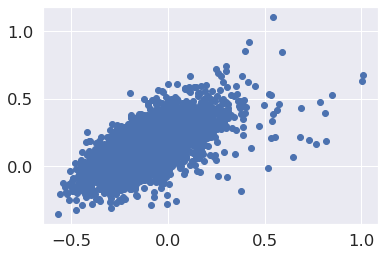

In [108]:
plt.scatter(model1.A_[:, 0], model1.A_[:, 1], cmap = 'hot')

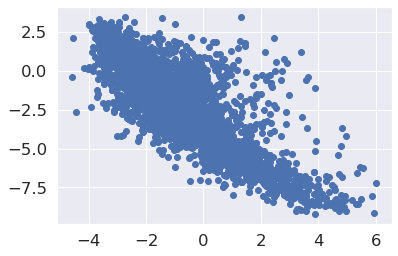

In [109]:
plt.scatter(model1.B_[:, 0], model1.B_[:, 1], cmap='hot')

In [113]:
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate

In [112]:
pip install surprise

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 771 kB 1.3 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=1265788 sha256=db091ae713453b2b05d92c4673b2988fa4d1ba30d61a57e79cd38b3528a58fd6
  Stored in directory: /home/T7820S1/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [114]:
user_itm = data[['UserID', 'Title', 'Rating']].copy()
reader = Reader(rating_scale=(1,5))
data1 = Dataset.load_from_df(user_itm[['UserID', 'Title', 'Rating']], reader)

In [115]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserID'].unique()))
print("No.of Items:",len(user_itm['Title'].unique()))

(996144, 3)
No.of Users: 6040
No.of Items: 3640


In [116]:
svd = SVD(n_factors=4)
cross_validate(svd, data1, measures=['rmse'], cv=3, return_train_measures=True)

{'test_rmse': array([0.89424727, 0.89106345, 0.89025349]),
 'train_rmse': array([0.86474692, 0.86305735, 0.85915489]),
 'fit_time': (2.436217784881592, 2.424826145172119, 2.570477247238159),
 'test_time': (2.0769598484039307, 1.4762723445892334, 1.509284257888794)}

In [117]:
trainset = data1.build_full_trainset()
svd.fit(trainset) 

In [118]:
items = movies['Title'].unique()
##Considering the user '662' 
test = [[662, iid, 4] for iid in items]
##Finding the user predictions(ratings) for all the movies
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [119]:
a = pred.sort_values(by='est', ascending=False) ##Sorting the values based on the estimated predictions

In [120]:
testset = trainset.build_anti_testset()

predictions_svd = svd.test(testset)

In [121]:
from surprise import accuracy
print('SVD - RMSE:', accuracy.rmse(predictions_svd, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions_svd, verbose=False))

SVD - RMSE: 0.7018863163179752
SVD - MAE: 0.5437153023570145


**Embeddings for user-user similarity using surprise library.**

In [122]:
user=cosine_similarity(svd.pu)

user_sim_matrix = pd.DataFrame(user, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()  #User similarity matrix using the embeddings from matrix factorization

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.189622,0.430302,0.710868,0.280567,0.025197,0.760086,0.617361,0.801332,-0.394802,...,-0.077328,0.577046,0.766832,-0.911736,0.830896,0.067849,0.316758,-0.370473,-0.400612,0.218997
10,0.189622,1.000000,-0.684949,-0.512037,0.829426,-0.522126,0.401671,0.144977,-0.011947,0.769164,...,0.648643,0.885007,0.187993,-0.428660,-0.022251,-0.262453,0.602476,-0.734247,0.728815,0.355420
100,0.430302,-0.684949,1.000000,0.914116,-0.692744,0.326021,0.378952,0.202421,0.516200,-0.837446,...,-0.810092,-0.428986,0.237478,-0.110402,0.553135,0.357475,-0.616639,0.608443,-0.925015,-0.458145
1000,0.710868,-0.512037,0.914116,1.000000,-0.367248,0.215924,0.508954,0.505320,0.773902,-0.802176,...,-0.549592,-0.159013,0.573215,-0.476015,0.803582,0.406315,-0.245794,0.338961,-0.833011,-0.277950
1001,0.280567,0.829426,-0.692744,-0.367248,1.000000,-0.585585,0.234845,0.492356,0.240617,0.672310,...,0.910486,0.792006,0.512235,-0.624562,0.206971,-0.001725,0.932303,-0.751254,0.750567,0.394245


**Embeddings for item-item similarity using surprise library.**

In [123]:
itm=cosine_similarity(svd.qi)

itm_sim_matrix = pd.DataFrame(itm) #, columns=user_itm['Title'].unique())
itm_sim_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639
0,1.000000,0.107492,0.798230,0.716463,0.921916,0.597203,0.952081,0.792443,0.891706,0.273401,...,0.935360,0.035654,0.214311,0.089468,0.540878,0.218204,-0.660547,0.826678,-0.075652,0.603601
1,0.107492,1.000000,0.501321,-0.291360,-0.005595,0.049529,0.345796,0.223367,0.338022,-0.822679,...,-0.143702,-0.422224,-0.279116,-0.864248,-0.124862,-0.934006,0.128915,0.196611,0.955065,-0.525334
2,0.798230,0.501321,1.000000,0.614763,0.717794,0.282055,0.898257,0.563228,0.782128,-0.325185,...,0.586694,-0.170099,-0.317064,-0.212237,0.404894,-0.177194,-0.488383,0.469788,0.297055,0.458513
3,0.716463,-0.291360,0.614763,1.000000,0.588267,-0.018387,0.567649,0.188112,0.374614,0.353253,...,0.782870,0.503231,0.041231,0.638364,0.202548,0.527325,-0.864606,0.266425,-0.384359,0.934171
4,0.921916,-0.005595,0.717794,0.588267,1.000000,0.774211,0.917047,0.888335,0.929917,0.283097,...,0.800259,-0.256500,0.028747,0.029488,0.823932,0.348296,-0.372944,0.755813,-0.255234,0.605431


In [128]:
itm

array([[ 1.        ,  0.10749228,  0.79822987, ...,  0.82667752,
        -0.07565165,  0.60360143],
       [ 0.10749228,  1.        ,  0.50132148, ...,  0.19661081,
         0.95506518, -0.52533416],
       [ 0.79822987,  0.50132148,  1.        , ...,  0.4697881 ,
         0.2970545 ,  0.45851291],
       ...,
       [ 0.82667752,  0.19661081,  0.4697881 , ...,  1.        ,
         0.08052552,  0.14107476],
       [-0.07565165,  0.95506518,  0.2970545 , ...,  0.08052552,
         1.        , -0.65222823],
       [ 0.60360143, -0.52533416,  0.45851291, ...,  0.14107476,
        -0.65222823,  1.        ]])

In [143]:
movie_name='Home Alone'
index = data.index[data['Title'] == movie_name][0]
index

415

In [144]:
movie_rating = itm_sim_matrix[index] # Taking the ratings of that movie
print(movie_rating)

0      -0.940438
1      -0.106817
2      -0.605670
3      -0.514532
4      -0.848261
          ...   
3635   -0.160222
3636    0.580465
3637   -0.963090
3638    0.029604
3639   -0.387376
Name: 415, Length: 3640, dtype: float64


In [145]:
similar_movies = itm_sim_matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head()

,Correlation
2618,0.995336
1912,0.995272
2631,0.994357
1712,0.992614
1890,0.987512


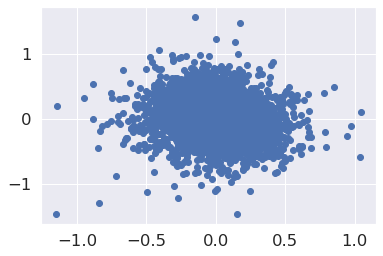

In [146]:
plt.scatter(svd.pu[:, 0], svd.pu[:, 1], cmap = 'hot')

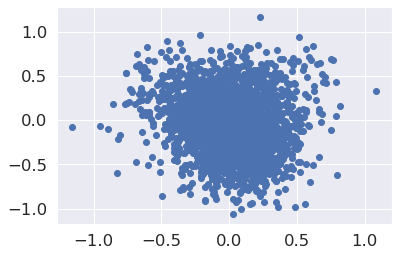

In [147]:
plt.scatter(svd.qi[:, 0], svd.qi[:, 1], cmap = 'hot')